In [109]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy.fuzzy_layer import FuzzyLayer


In [110]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
fuzzy_dim = 2
beta = 1
gamma = 1 
fuzzy_labels = 10 #10 numbers 
unknown_classes_ratio = 0.0 # unknow samples rate
is_fuzzy_loss_active = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_fuzzy_loss_active:
    gamma = 1
else:
    gamma = 0

In [111]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [112]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [113]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [114]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [115]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [116]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [117]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [118]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count, fuzzy_dim):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)
        self.fuzzy_dim = fuzzy_dim
        self.fuzzy = nn.Sequential(
            FuzzyLayer.fromdimentions(fuzzy_dim, labels_count, trainable=True)
        )
        
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        
        labels = self.fuzzy(mu[:, 0:self.fuzzy_dim])

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu[:, 0:self.fuzzy_dim])

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [119]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + beta * loss_kl + gamma * loss_fuzzy

    

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [120]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels, fuzzy_dim=fuzzy_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,690,317


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [121]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [122]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [123]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:, 0:10].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [124]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)


Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 19.1430 (Recon: 17.5390, KL: 0.2622 Fuzzy: 1.3417) Grad: 14.1131
Step 100 (N samples: 25,600), Loss: 8.3713 (Recon: 7.1305, KL: 0.3303 Fuzzy: 0.9105) Grad: 3.9809
Step 200 (N samples: 51,200), Loss: 8.1777 (Recon: 6.8894, KL: 0.4359 Fuzzy: 0.8524) Grad: 3.2613


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.1516 (BCE: 6.8996, KLD: 0.4539 Fuzzy: 0.7981 Accuracy 0.3453)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 8.1770 (Recon: 6.9145, KL: 0.4870 Fuzzy: 0.7755) Grad: 6.1204
Step 400 (N samples: 102,400), Loss: 7.8414 (Recon: 6.5548, KL: 0.5782 Fuzzy: 0.7084) Grad: 3.7932


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.8175 (BCE: 6.5747, KLD: 0.5948 Fuzzy: 0.6480 Accuracy 0.5254)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.8287 (Recon: 6.5668, KL: 0.6097 Fuzzy: 0.6522) Grad: 5.4738
Step 600 (N samples: 153,600), Loss: 7.8997 (Recon: 6.6525, KL: 0.6542 Fuzzy: 0.5930) Grad: 4.8394
Step 700 (N samples: 179,200), Loss: 7.7470 (Recon: 6.4386, KL: 0.7319 Fuzzy: 0.5766) Grad: 3.6448


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.0050 (BCE: 6.2904, KLD: 1.0770 Fuzzy: 0.6375 Accuracy 0.5481)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.7060 (Recon: 6.4095, KL: 0.7615 Fuzzy: 0.5351) Grad: 5.2259
Step 900 (N samples: 230,400), Loss: 7.7008 (Recon: 6.3735, KL: 0.7965 Fuzzy: 0.5308) Grad: 2.1821


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5796 (BCE: 6.2158, KLD: 0.8526 Fuzzy: 0.5112 Accuracy 0.6149)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.7001 (Recon: 6.4117, KL: 0.7940 Fuzzy: 0.4945) Grad: 2.9305
Step 1,100 (N samples: 281,600), Loss: 7.4477 (Recon: 6.0666, KL: 0.8508 Fuzzy: 0.5303) Grad: 3.4298


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5447 (BCE: 6.2326, KLD: 0.8191 Fuzzy: 0.4930 Accuracy 0.6581)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.5446 (Recon: 6.2406, KL: 0.8182 Fuzzy: 0.4859) Grad: 2.2699
Step 1,300 (N samples: 332,800), Loss: 7.9093 (Recon: 6.5407, KL: 0.8279 Fuzzy: 0.5407) Grad: 2.3239
Step 1,400 (N samples: 358,400), Loss: 7.6853 (Recon: 6.2802, KL: 0.9044 Fuzzy: 0.5007) Grad: 2.7001


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5221 (BCE: 6.2052, KLD: 0.8336 Fuzzy: 0.4834 Accuracy 0.7058)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.5818 (Recon: 6.2400, KL: 0.8658 Fuzzy: 0.4760) Grad: 2.7049
Step 1,600 (N samples: 409,600), Loss: 7.6954 (Recon: 6.3667, KL: 0.8528 Fuzzy: 0.4759) Grad: 3.6387


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4698 (BCE: 6.1642, KLD: 0.8594 Fuzzy: 0.4462 Accuracy 0.7585)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.7244 (Recon: 6.3444, KL: 0.8865 Fuzzy: 0.4935) Grad: 3.0933
Step 1,800 (N samples: 460,800), Loss: 7.5086 (Recon: 6.1877, KL: 0.8937 Fuzzy: 0.4272) Grad: 2.1639


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4192 (BCE: 6.1818, KLD: 0.8586 Fuzzy: 0.3787 Accuracy 0.8354)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.3847 (Recon: 6.0768, KL: 0.9029 Fuzzy: 0.4050) Grad: 2.2460
Step 2,000 (N samples: 512,000), Loss: 7.4556 (Recon: 6.2137, KL: 0.8966 Fuzzy: 0.3453) Grad: 2.0561
Step 2,100 (N samples: 537,600), Loss: 7.7110 (Recon: 6.4867, KL: 0.8707 Fuzzy: 0.3535) Grad: 2.6850


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3558 (BCE: 6.1767, KLD: 0.8782 Fuzzy: 0.3008 Accuracy 0.8955)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.7159 (Recon: 6.5019, KL: 0.8929 Fuzzy: 0.3211) Grad: 3.8032
Step 2,300 (N samples: 588,800), Loss: 7.4906 (Recon: 6.3121, KL: 0.8925 Fuzzy: 0.2860) Grad: 2.9759


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3495 (BCE: 6.1256, KLD: 0.9547 Fuzzy: 0.2692 Accuracy 0.9093)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.4720 (Recon: 6.2593, KL: 0.9359 Fuzzy: 0.2768) Grad: 3.2774
Step 2,500 (N samples: 640,000), Loss: 7.3439 (Recon: 6.1307, KL: 0.9357 Fuzzy: 0.2775) Grad: 2.1882


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3335 (BCE: 6.2042, KLD: 0.8674 Fuzzy: 0.2620 Accuracy 0.9202)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.2929 (Recon: 6.1076, KL: 0.9250 Fuzzy: 0.2603) Grad: 3.3747
Step 2,700 (N samples: 691,200), Loss: 7.4200 (Recon: 6.2395, KL: 0.9137 Fuzzy: 0.2668) Grad: 2.3220
Step 2,800 (N samples: 716,800), Loss: 7.5236 (Recon: 6.3347, KL: 0.9318 Fuzzy: 0.2571) Grad: 2.4612


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2847 (BCE: 6.0825, KLD: 0.9690 Fuzzy: 0.2331 Accuracy 0.9332)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.3158 (Recon: 6.1710, KL: 0.8958 Fuzzy: 0.2490) Grad: 2.5110
Step 3,000 (N samples: 768,000), Loss: 7.3108 (Recon: 6.1721, KL: 0.9244 Fuzzy: 0.2143) Grad: 2.1351


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2879 (BCE: 6.1096, KLD: 0.9414 Fuzzy: 0.2369 Accuracy 0.9304)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.3754 (Recon: 6.2163, KL: 0.9189 Fuzzy: 0.2402) Grad: 2.8630
Step 3,200 (N samples: 819,200), Loss: 7.3248 (Recon: 6.1885, KL: 0.9352 Fuzzy: 0.2011) Grad: 2.8228


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2607 (BCE: 6.0942, KLD: 0.9479 Fuzzy: 0.2186 Accuracy 0.9416)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.3000 (Recon: 6.1507, KL: 0.9024 Fuzzy: 0.2469) Grad: 2.2710
Step 3,400 (N samples: 870,400), Loss: 7.2985 (Recon: 6.1255, KL: 0.9255 Fuzzy: 0.2475) Grad: 2.6422
Step 3,500 (N samples: 896,000), Loss: 7.4473 (Recon: 6.2752, KL: 0.9376 Fuzzy: 0.2345) Grad: 2.7015


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2519 (BCE: 6.1166, KLD: 0.9224 Fuzzy: 0.2129 Accuracy 0.9428)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.5412 (Recon: 6.3490, KL: 0.9205 Fuzzy: 0.2717) Grad: 2.7678
Step 3,700 (N samples: 947,200), Loss: 7.4220 (Recon: 6.2041, KL: 0.9845 Fuzzy: 0.2334) Grad: 3.0484


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2526 (BCE: 6.0920, KLD: 0.9589 Fuzzy: 0.2018 Accuracy 0.9435)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 7.2315 (Recon: 6.0830, KL: 0.9427 Fuzzy: 0.2057) Grad: 2.6134
Step 3,900 (N samples: 998,400), Loss: 7.1792 (Recon: 6.0336, KL: 0.9390 Fuzzy: 0.2066) Grad: 2.9755


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2252 (BCE: 6.0995, KLD: 0.9316 Fuzzy: 0.1941 Accuracy 0.9514)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.1523 (Recon: 5.9834, KL: 0.9923 Fuzzy: 0.1765) Grad: 2.8244
Step 4,100 (N samples: 1,049,600), Loss: 7.3290 (Recon: 6.1872, KL: 0.9465 Fuzzy: 0.1953) Grad: 2.5305
Step 4,200 (N samples: 1,075,200), Loss: 7.2544 (Recon: 6.1631, KL: 0.9189 Fuzzy: 0.1723) Grad: 1.7433


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2181 (BCE: 6.0808, KLD: 0.9574 Fuzzy: 0.1799 Accuracy 0.9519)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.0676 (Recon: 5.9364, KL: 0.9399 Fuzzy: 0.1913) Grad: 3.4458
Step 4,400 (N samples: 1,126,400), Loss: 7.3756 (Recon: 6.1627, KL: 0.9802 Fuzzy: 0.2328) Grad: 2.4718


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1926 (BCE: 6.0722, KLD: 0.9408 Fuzzy: 0.1796 Accuracy 0.9549)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.2721 (Recon: 6.1703, KL: 0.9344 Fuzzy: 0.1674) Grad: 3.0284
Step 4,600 (N samples: 1,177,600), Loss: 7.3973 (Recon: 6.2604, KL: 0.9341 Fuzzy: 0.2028) Grad: 2.0386


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2173 (BCE: 6.1100, KLD: 0.9243 Fuzzy: 0.1830 Accuracy 0.9541)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 7.1450 (Recon: 6.0096, KL: 0.9226 Fuzzy: 0.2128) Grad: 3.0578
Step 4,800 (N samples: 1,228,800), Loss: 7.2214 (Recon: 6.0573, KL: 0.9802 Fuzzy: 0.1839) Grad: 2.2220
Step 4,900 (N samples: 1,254,400), Loss: 7.0690 (Recon: 5.8867, KL: 0.9748 Fuzzy: 0.2076) Grad: 1.7773


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2268 (BCE: 6.0861, KLD: 0.9634 Fuzzy: 0.1773 Accuracy 0.9584)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.4393 (Recon: 6.2490, KL: 1.0014 Fuzzy: 0.1889) Grad: 1.9092
Step 5,100 (N samples: 1,305,600), Loss: 7.3865 (Recon: 6.2034, KL: 1.0029 Fuzzy: 0.1802) Grad: 2.0733


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2162 (BCE: 6.0483, KLD: 0.9902 Fuzzy: 0.1777 Accuracy 0.9548)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.1755 (Recon: 6.0125, KL: 0.9719 Fuzzy: 0.1911) Grad: 1.5782
Step 5,300 (N samples: 1,356,800), Loss: 7.2448 (Recon: 6.0894, KL: 0.9795 Fuzzy: 0.1758) Grad: 2.0037
Step 5,400 (N samples: 1,382,400), Loss: 7.0226 (Recon: 5.8984, KL: 0.9794 Fuzzy: 0.1448) Grad: 1.5272


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1720 (BCE: 6.0096, KLD: 0.9954 Fuzzy: 0.1671 Accuracy 0.9536)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 7.2480 (Recon: 6.0050, KL: 0.9772 Fuzzy: 0.2657) Grad: 2.9753
Step 5,600 (N samples: 1,433,600), Loss: 7.1462 (Recon: 5.9353, KL: 0.9944 Fuzzy: 0.2165) Grad: 2.9377


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1821 (BCE: 6.0004, KLD: 1.0093 Fuzzy: 0.1724 Accuracy 0.9522)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.0122 (Recon: 5.8712, KL: 0.9850 Fuzzy: 0.1560) Grad: 1.8891
Step 5,800 (N samples: 1,484,800), Loss: 7.3436 (Recon: 6.1663, KL: 0.9779 Fuzzy: 0.1994) Grad: 2.4350


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1647 (BCE: 6.0205, KLD: 0.9777 Fuzzy: 0.1664 Accuracy 0.9587)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.1720 (Recon: 6.0036, KL: 1.0115 Fuzzy: 0.1569) Grad: 1.9165
Step 6,000 (N samples: 1,536,000), Loss: 7.1269 (Recon: 5.9652, KL: 0.9933 Fuzzy: 0.1684) Grad: 1.6253
Step 6,100 (N samples: 1,561,600), Loss: 7.3362 (Recon: 6.1724, KL: 0.9674 Fuzzy: 0.1964) Grad: 2.2256


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1901 (BCE: 6.0569, KLD: 0.9743 Fuzzy: 0.1589 Accuracy 0.9596)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.2262 (Recon: 6.0362, KL: 1.0248 Fuzzy: 0.1651) Grad: 1.8371
Step 6,300 (N samples: 1,612,800), Loss: 7.3185 (Recon: 6.1411, KL: 0.9814 Fuzzy: 0.1960) Grad: 2.1660


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1679 (BCE: 5.9901, KLD: 1.0238 Fuzzy: 0.1540 Accuracy 0.9604)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.4283 (Recon: 6.2375, KL: 1.0172 Fuzzy: 0.1736) Grad: 1.6209
Step 6,500 (N samples: 1,664,000), Loss: 7.1344 (Recon: 5.9387, KL: 1.0276 Fuzzy: 0.1680) Grad: 1.6152


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1697 (BCE: 6.0030, KLD: 1.0060 Fuzzy: 0.1607 Accuracy 0.9604)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 7.3578 (Recon: 6.2027, KL: 0.9642 Fuzzy: 0.1909) Grad: 2.7344
Step 6,700 (N samples: 1,715,200), Loss: 7.1228 (Recon: 5.9337, KL: 1.0160 Fuzzy: 0.1731) Grad: 1.3991
Step 6,800 (N samples: 1,740,800), Loss: 7.2061 (Recon: 5.9921, KL: 1.0528 Fuzzy: 0.1612) Grad: 2.5019


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1637 (BCE: 5.9847, KLD: 1.0239 Fuzzy: 0.1551 Accuracy 0.9613)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.3549 (Recon: 6.1970, KL: 0.9755 Fuzzy: 0.1824) Grad: 1.7292
Step 7,000 (N samples: 1,792,000), Loss: 7.0592 (Recon: 5.8926, KL: 1.0113 Fuzzy: 0.1553) Grad: 1.7606


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1699 (BCE: 6.0302, KLD: 0.9823 Fuzzy: 0.1574 Accuracy 0.9593)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.3134 (Recon: 6.1151, KL: 1.0261 Fuzzy: 0.1721) Grad: 1.3878
Step 7,200 (N samples: 1,843,200), Loss: 7.2642 (Recon: 6.1190, KL: 0.9861 Fuzzy: 0.1590) Grad: 2.4534


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1643 (BCE: 6.0055, KLD: 0.9973 Fuzzy: 0.1615 Accuracy 0.9599)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 7.1269 (Recon: 5.9541, KL: 1.0096 Fuzzy: 0.1632) Grad: 1.4800
Step 7,400 (N samples: 1,894,400), Loss: 7.2681 (Recon: 6.0768, KL: 1.0159 Fuzzy: 0.1754) Grad: 2.7835
Step 7,500 (N samples: 1,920,000), Loss: 7.2590 (Recon: 6.0805, KL: 1.0185 Fuzzy: 0.1599) Grad: 1.6929


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1521 (BCE: 5.9928, KLD: 1.0054 Fuzzy: 0.1540 Accuracy 0.9610)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 7.1095 (Recon: 5.9391, KL: 1.0210 Fuzzy: 0.1494) Grad: 1.9873
Step 7,700 (N samples: 1,971,200), Loss: 7.3440 (Recon: 6.1731, KL: 1.0016 Fuzzy: 0.1693) Grad: 2.3361


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1476 (BCE: 5.9735, KLD: 1.0253 Fuzzy: 0.1488 Accuracy 0.9646)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 7.1031 (Recon: 5.9113, KL: 1.0253 Fuzzy: 0.1665) Grad: 1.5174
Step 7,900 (N samples: 2,022,400), Loss: 7.0302 (Recon: 5.8267, KL: 1.0368 Fuzzy: 0.1667) Grad: 1.7360


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1714 (BCE: 5.9904, KLD: 1.0125 Fuzzy: 0.1685 Accuracy 0.9610)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 6.9900 (Recon: 5.8026, KL: 1.0451 Fuzzy: 0.1424) Grad: 2.3741
Step 8,100 (N samples: 2,073,600), Loss: 7.2647 (Recon: 6.1111, KL: 1.0029 Fuzzy: 0.1507) Grad: 1.5299
Step 8,200 (N samples: 2,099,200), Loss: 7.2279 (Recon: 5.9944, KL: 1.0671 Fuzzy: 0.1664) Grad: 1.9461


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1758 (BCE: 6.0368, KLD: 0.9814 Fuzzy: 0.1575 Accuracy 0.9604)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 7.0170 (Recon: 5.8260, KL: 1.0335 Fuzzy: 0.1575) Grad: 1.7249
Step 8,400 (N samples: 2,150,400), Loss: 7.1334 (Recon: 5.9346, KL: 1.0358 Fuzzy: 0.1629) Grad: 1.3448


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1694 (BCE: 5.9826, KLD: 1.0388 Fuzzy: 0.1479 Accuracy 0.9636)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 7.1666 (Recon: 5.9885, KL: 1.0246 Fuzzy: 0.1534) Grad: 2.6187
Step 8,600 (N samples: 2,201,600), Loss: 7.2930 (Recon: 6.0888, KL: 1.0365 Fuzzy: 0.1677) Grad: 2.7008


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1634 (BCE: 5.9553, KLD: 1.0600 Fuzzy: 0.1481 Accuracy 0.9603)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 7.3133 (Recon: 6.1132, KL: 1.0287 Fuzzy: 0.1714) Grad: 2.6498
Step 8,800 (N samples: 2,252,800), Loss: 7.0639 (Recon: 5.8402, KL: 1.0643 Fuzzy: 0.1594) Grad: 1.7621
Step 8,900 (N samples: 2,278,400), Loss: 7.1681 (Recon: 5.9787, KL: 0.9943 Fuzzy: 0.1951) Grad: 1.9587


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1384 (BCE: 5.9514, KLD: 1.0459 Fuzzy: 0.1412 Accuracy 0.9646)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 7.1070 (Recon: 5.9218, KL: 0.9976 Fuzzy: 0.1876) Grad: 2.5018
Step 9,100 (N samples: 2,329,600), Loss: 7.2144 (Recon: 6.0099, KL: 1.0527 Fuzzy: 0.1518) Grad: 1.6951


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1568 (BCE: 5.9755, KLD: 1.0306 Fuzzy: 0.1507 Accuracy 0.9649)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 7.1057 (Recon: 5.9329, KL: 1.0165 Fuzzy: 0.1563) Grad: 2.0693
Step 9,300 (N samples: 2,380,800), Loss: 7.3387 (Recon: 6.1637, KL: 1.0271 Fuzzy: 0.1480) Grad: 1.5553


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1393 (BCE: 5.9828, KLD: 1.0003 Fuzzy: 0.1562 Accuracy 0.9609)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 7.1709 (Recon: 6.0102, KL: 0.9960 Fuzzy: 0.1647) Grad: 1.8680
Step 9,500 (N samples: 2,432,000), Loss: 7.1776 (Recon: 5.9396, KL: 1.0553 Fuzzy: 0.1827) Grad: 2.3386
Step 9,600 (N samples: 2,457,600), Loss: 7.2475 (Recon: 6.0582, KL: 1.0423 Fuzzy: 0.1470) Grad: 2.4544


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1324 (BCE: 5.9614, KLD: 1.0260 Fuzzy: 0.1450 Accuracy 0.9624)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 7.3498 (Recon: 6.1604, KL: 1.0587 Fuzzy: 0.1307) Grad: 1.7987
Step 9,800 (N samples: 2,508,800), Loss: 6.9480 (Recon: 5.7190, KL: 1.0445 Fuzzy: 0.1846) Grad: 2.0704


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1665 (BCE: 5.9487, KLD: 1.0677 Fuzzy: 0.1502 Accuracy 0.9638)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 7.1447 (Recon: 5.9281, KL: 1.0481 Fuzzy: 0.1685) Grad: 2.0370
Step 10,000 (N samples: 2,560,000), Loss: 7.0705 (Recon: 5.8010, KL: 1.0788 Fuzzy: 0.1907) Grad: 1.8659
Step 10,100 (N samples: 2,585,600), Loss: 7.1411 (Recon: 5.9720, KL: 0.9895 Fuzzy: 0.1796) Grad: 2.0576


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1317 (BCE: 5.9537, KLD: 1.0318 Fuzzy: 0.1462 Accuracy 0.9625)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 7.2270 (Recon: 6.0347, KL: 1.0511 Fuzzy: 0.1412) Grad: 1.9581
Step 10,300 (N samples: 2,636,800), Loss: 7.0269 (Recon: 5.8129, KL: 1.0546 Fuzzy: 0.1595) Grad: 2.0674


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1312 (BCE: 5.9220, KLD: 1.0660 Fuzzy: 0.1432 Accuracy 0.9626)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 7.1259 (Recon: 5.8882, KL: 1.0697 Fuzzy: 0.1681) Grad: 1.7098
Step 10,500 (N samples: 2,688,000), Loss: 6.9896 (Recon: 5.7948, KL: 1.0461 Fuzzy: 0.1487) Grad: 1.2611


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1122 (BCE: 5.9277, KLD: 1.0417 Fuzzy: 0.1428 Accuracy 0.9627)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 6.9949 (Recon: 5.8208, KL: 1.0546 Fuzzy: 0.1196) Grad: 1.3504
Step 10,700 (N samples: 2,739,200), Loss: 7.1504 (Recon: 5.9328, KL: 1.0721 Fuzzy: 0.1456) Grad: 1.2844
Step 10,800 (N samples: 2,764,800), Loss: 7.2652 (Recon: 6.1069, KL: 1.0173 Fuzzy: 0.1410) Grad: 2.1910


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1272 (BCE: 5.9005, KLD: 1.0818 Fuzzy: 0.1449 Accuracy 0.9617)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 7.1197 (Recon: 5.9064, KL: 1.0604 Fuzzy: 0.1529) Grad: 2.2024
Step 11,000 (N samples: 2,816,000), Loss: 6.9776 (Recon: 5.7487, KL: 1.0658 Fuzzy: 0.1630) Grad: 1.5435


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1332 (BCE: 5.9507, KLD: 1.0377 Fuzzy: 0.1449 Accuracy 0.9627)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 7.0987 (Recon: 5.8804, KL: 1.0838 Fuzzy: 0.1345) Grad: 2.6913
Step 11,200 (N samples: 2,867,200), Loss: 7.3416 (Recon: 6.1172, KL: 1.0674 Fuzzy: 0.1569) Grad: 1.9273


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1357 (BCE: 5.9050, KLD: 1.0843 Fuzzy: 0.1465 Accuracy 0.9667)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 7.2342 (Recon: 5.9626, KL: 1.0935 Fuzzy: 0.1780) Grad: 2.3621
Step 11,400 (N samples: 2,918,400), Loss: 7.1523 (Recon: 5.9379, KL: 1.0756 Fuzzy: 0.1387) Grad: 1.6460
Step 11,500 (N samples: 2,944,000), Loss: 7.0147 (Recon: 5.8204, KL: 1.0417 Fuzzy: 0.1526) Grad: 1.9295


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1317 (BCE: 5.9250, KLD: 1.0575 Fuzzy: 0.1492 Accuracy 0.9653)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 6.9692 (Recon: 5.7667, KL: 1.0534 Fuzzy: 0.1491) Grad: 2.6526
Step 11,700 (N samples: 2,995,200), Loss: 7.2417 (Recon: 6.0270, KL: 1.0555 Fuzzy: 0.1592) Grad: 1.9630


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1260 (BCE: 5.9059, KLD: 1.0815 Fuzzy: 0.1386 Accuracy 0.9655)


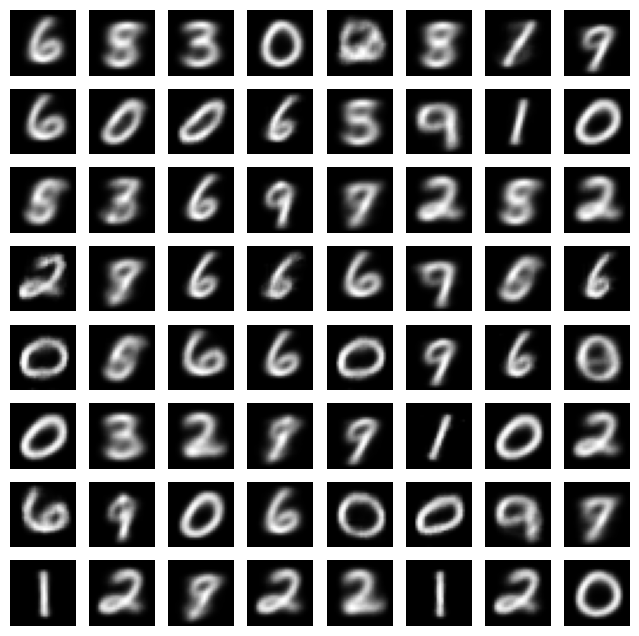

In [125]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [146]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
std_all = []
y_all = []
pred_y_all = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, logvar, z, labels = model.half_pass(data)
        z_all.append(mu.cpu().numpy())
        std_all.append(logvar.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:10].cpu().numpy(), axis=1))

z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
std_all = np.concatenate(std_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [154]:
from collections import defaultdict

data_centroids_dict = defaultdict(list)
data_std_dict = defaultdict(list)

for mu, y, std in zip(z_all, pred_y_all, std_all):
    data_centroids_dict[y].append(mu)
    data_std_dict[y].append(np.exp(std))

cluster_centroids_from_data = []
cluster_std_from_data = []
for numb in range(0,10):
    cluster_centroids_from_data.append(np.mean(data_centroids_dict[numb], axis=0))
    cluster_std_from_data.append(np.mean(data_std_dict[numb], axis=0))

cluster_std_from_data

[array([0.2, 0.2], dtype=float32),
 array([0.3, 0.3], dtype=float32),
 array([0.3, 0.3], dtype=float32),
 array([0.4, 0.2], dtype=float32),
 array([0.3, 0.3], dtype=float32),
 array([0.6, 0.2], dtype=float32),
 array([0.3, 0.3], dtype=float32),
 array([0.2, 0.2], dtype=float32),
 array([0.5, 0.2], dtype=float32),
 array([0.2, 0.3], dtype=float32)]

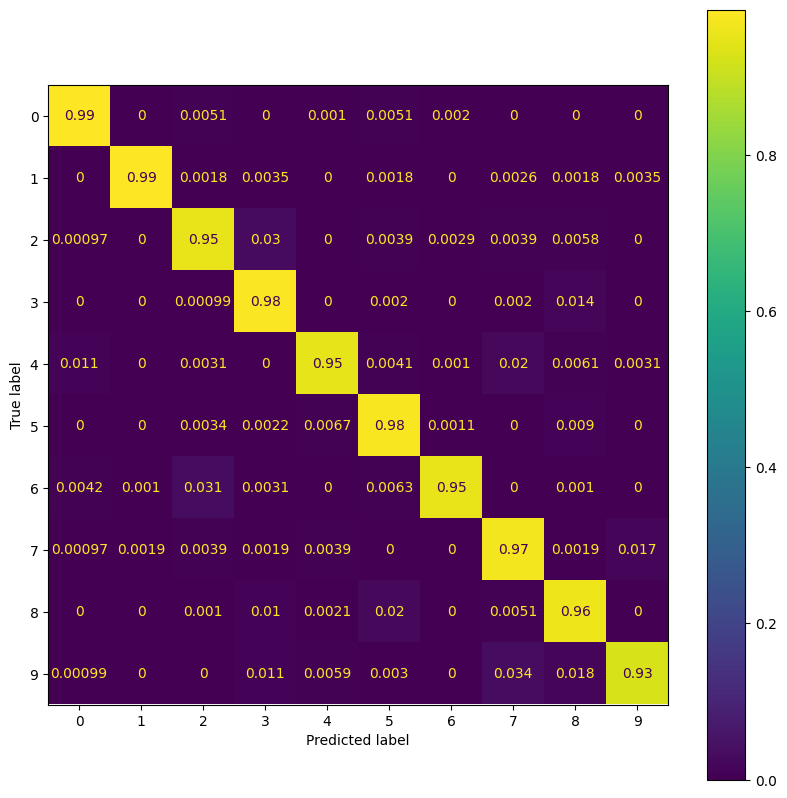

In [130]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize = (10, 10))
cmd.plot(ax=ax)

Text(0, 0.5, 'cvae 2')

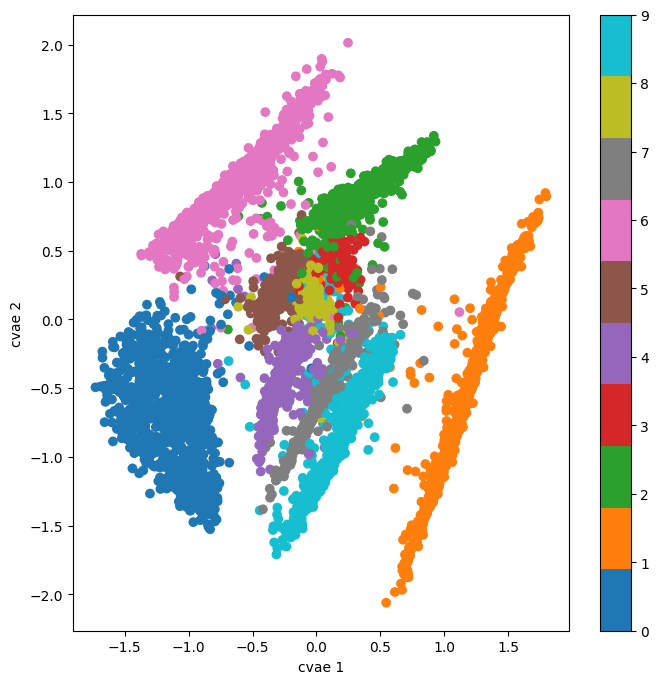

In [131]:
plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")

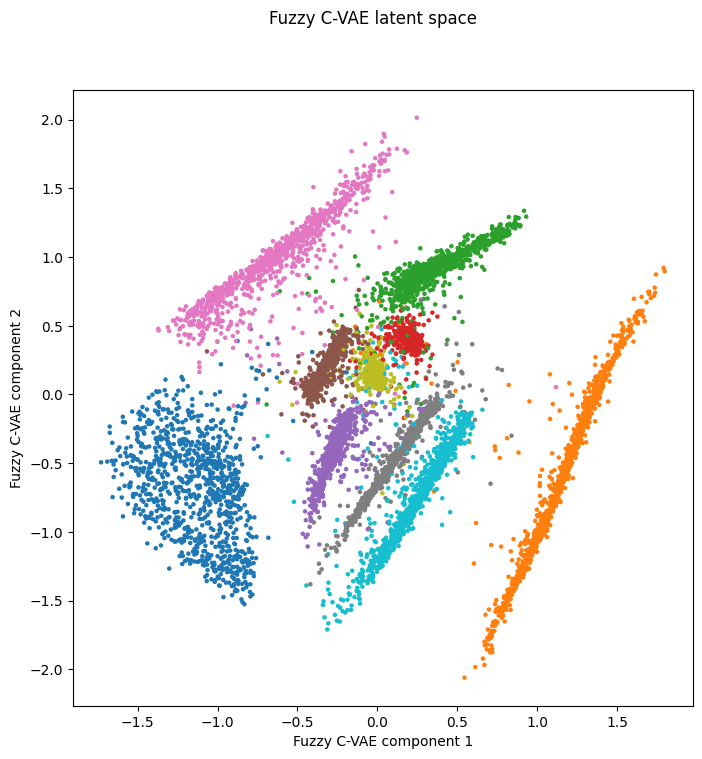

In [132]:
mask = "Fuzzy C-VAE"
if not is_fuzzy_loss_active:
    mask = "VAE"
import matplotlib.colors
# figure, axis = plt.subplots(2, 3, figsize=(17, 10)) 
# axis[0][0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
# axis[0][0].set_title("")
# axis[0][0].set_xlabel(f"{mask} component 1")
# axis[0][0].set_ylabel(f"{mask} component 2")


plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=5)
plt.xlabel(f"{mask} component 1")
plt.ylabel(f"{mask} component 2")
plt.suptitle(f'{mask} latent space')
if is_fuzzy_loss_active:
    plt.savefig('papers/iiti24/fig2b-fcvae-all-features.eps', format='eps')
else:
    plt.savefig('papers/iiti24/fig2a-vae-all-features.eps', format='eps')
plt.show()


In [133]:
domains_scatter_points = []
for x in np.linspace(-1.9, 2.0, 200):
    for y in np.linspace(-1.2, 2, 200):
        fuzzy_inference = model.fuzzy.forward(torch.FloatTensor([[x,y]]).to(device)).cpu().detach().numpy()
        fuzzy_class =np.argmax(fuzzy_inference[0,0:10])
        domains_scatter_points.append([x,y,fuzzy_class])

domains_scatter_points = np.array(domains_scatter_points)

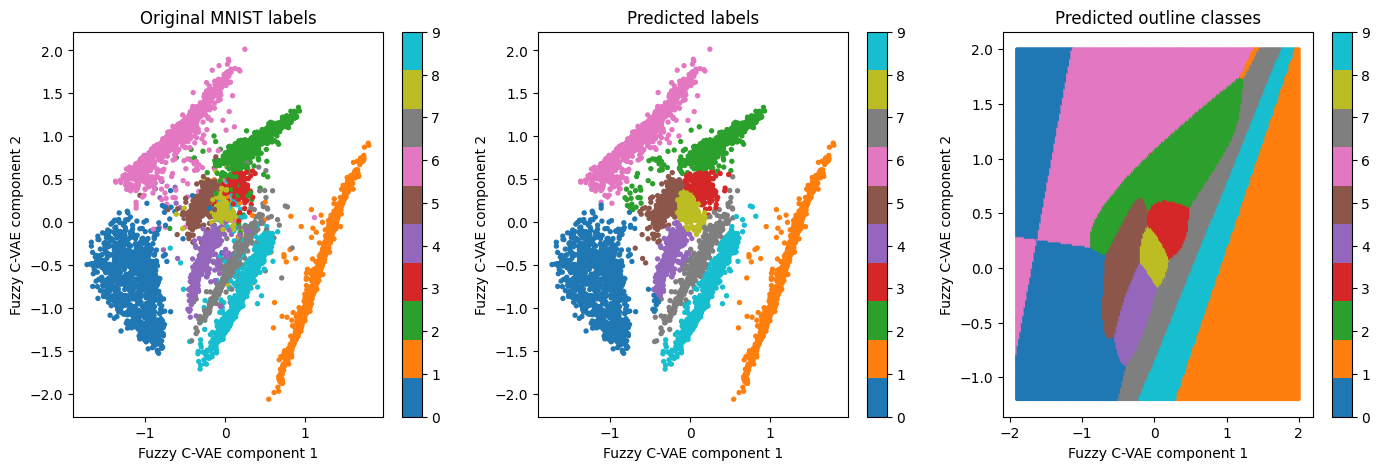

In [134]:
import matplotlib.colors
figure, axis = plt.subplots(1, 3, figsize=(17, 5)) 
sc1 =axis[0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
axis[0].set_title("Original MNIST labels")
axis[0].set_xlabel(f"{mask} component 1")
axis[0].set_ylabel(f"{mask} component 2")

sc2 = axis[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10', s=8)
axis[1].set_title("Predicted labels") 
axis[1].set_xlabel(f"{mask} component 1")
axis[1].set_ylabel(f"{mask} component 2")
tmm_cmap = matplotlib.colors.ListedColormap(['red', 'green'])

sc3 = axis[2].scatter(domains_scatter_points[:, 0], domains_scatter_points[:, 1], c = domains_scatter_points[:, 2], s=3, cmap='tab10')
axis[2].set_title("Predicted outline classes") 
axis[2].set_xlabel(f"{mask} component 1")
axis[2].set_ylabel(f"{mask} component 2")
figure.colorbar(sc1)
figure.colorbar(sc2)
figure.colorbar(sc3)

if is_fuzzy_loss_active:
    plt.savefig('papers/iiti24/fig3-fcvae-classification.eps', format="eps")
plt.show()

## Data generation

torch.Size([10, 2])


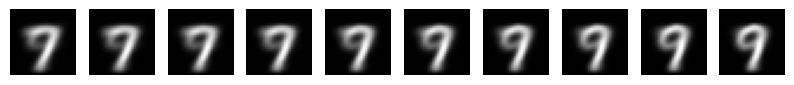

In [135]:
n = 10
path_from_4_to_9 = np.linspace(cluster_centroids_from_data[7], cluster_centroids_from_data[9], n)
path_from_4_to_9 = [torch.FloatTensor(a) for a in path_from_4_to_9]

z = torch.stack(path_from_4_to_9, dim=0).to(device)
print(z.shape)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('papers/iiti24/fig4-sample-generation.eps', format="eps")
plt.show()


tensor([[0.1067, 0.7945]], device='cuda:0', grad_fn=<SplitBackward>)
[[0.  0.  0.7 0.2 0.  0.2 0.1 0.  0.  0. ]]


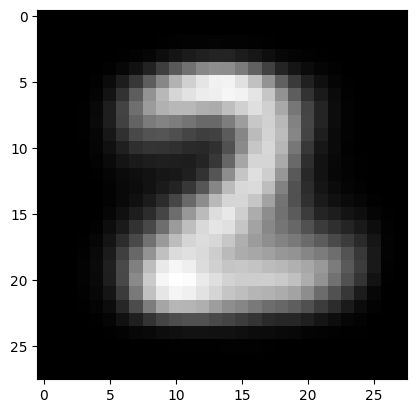

In [136]:

mu, std, z, fz = model.half_pass(test_data[1][0].reshape((1,1,28,28)).to(device))

# mu[0][0] = -2.8242958
# mu[0][1] = -0.39727297

print(mu)
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
print(fz.cpu().detach().numpy())
samples = model.decoder_pass(mu)
#samples = torch.sigmoid(samples)
plt.imshow(samples[0].view(28, 28).cpu().detach().numpy(), cmap='gray')
    

## Anomaly detection

In [137]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [138]:
import pandas as pd

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.csv")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]

len(emnist_x)

C:\Users\Юрий\AppData\Local\Temp\ipykernel_24492\2301690307.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]


103600

In [139]:
emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))
emnist_mapping

{1: 'Aa',
 2: 'Bb',
 3: 'Cc',
 4: 'Dd',
 5: 'Ee',
 6: 'Ff',
 7: 'Gg',
 8: 'Hh',
 9: 'Ii',
 10: 'Jj',
 11: 'Kk',
 12: 'Ll',
 13: 'Mm',
 14: 'Nn',
 15: 'Oo',
 16: 'Pp',
 17: 'Qq',
 18: 'Rr',
 19: 'Ss',
 20: 'Tt',
 21: 'Uu',
 22: 'Vv',
 23: 'Ww',
 24: 'Xx',
 25: 'Yy',
 26: 'Zz'}

In [140]:
model.eval()

anomaly_rates = defaultdict(list)

with torch.no_grad():
    for data, label in zip(emnist_x, emnist_y):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, flabels= model.forward(data)
        
        max_firing = flabels[0][0:10].max().cpu().numpy()
        anomaly_rates[emnist_mapping[label]].append(max_firing)

anomaly_rates

defaultdict(list,
            {'Aa': [array(0.4, dtype=float32),
              array(0.7, dtype=float32),
              array(0.8, dtype=float32),
              array(0.4, dtype=float32),
              array(0.3, dtype=float32),
              array(0.3, dtype=float32),
              array(0.3, dtype=float32),
              array(0.4, dtype=float32),
              array(0.4, dtype=float32),
              array(0.6, dtype=float32),
              array(0.4, dtype=float32),
              array(0.3, dtype=float32),
              array(0.9, dtype=float32),
              array(0.8, dtype=float32),
              array(0.7, dtype=float32),
              array(0.5, dtype=float32),
              array(0.5, dtype=float32),
              array(0.9, dtype=float32),
              array(0.4, dtype=float32),
              array(0.6, dtype=float32),
              array(0.3, dtype=float32),
              array(0.5, dtype=float32),
              array(0.5, dtype=float32),
              array(0.5, dtype=fl

In [141]:
anomaly_stats = []

for k in anomaly_rates.keys():
    anomaly_stats.append(
        {
            'Letters': k,
            'Mean': np.mean(anomaly_rates[k]),
            'Std': np.std(anomaly_rates[k]),
            'Max': np.max(anomaly_rates[k]),
        }
    )
pd.DataFrame(anomaly_stats)

,Letters,Mean,Std,Max
0,Aa,0.454899,0.184004,0.999116
1,Bb,0.489498,0.177010,0.999510
2,Cc,0.623452,0.213427,0.999227
3,Dd,0.519822,0.192407,0.999036
4,Ee,0.605889,0.215323,0.998564
5,Ff,0.465438,0.149046,0.975693
6,Gg,0.482192,0.165787,0.997803
7,Hh,0.479907,0.162559,0.982832
8,Ii,0.519978,0.164516,0.996656
9,Jj,0.492800,0.170025,0.995087


In [142]:
pd.DataFrame(anomaly_stats).to_latex()

'\\begin{tabular}{llrrr}\n\\toprule\n & Letters & Mean & Std & Max \\\\\n\\midrule\n0 & Aa & 0.454899 & 0.184004 & 0.999116 \\\\\n1 & Bb & 0.489498 & 0.177010 & 0.999510 \\\\\n2 & Cc & 0.623452 & 0.213427 & 0.999227 \\\\\n3 & Dd & 0.519822 & 0.192407 & 0.999036 \\\\\n4 & Ee & 0.605889 & 0.215323 & 0.998564 \\\\\n5 & Ff & 0.465438 & 0.149046 & 0.975693 \\\\\n6 & Gg & 0.482192 & 0.165787 & 0.997803 \\\\\n7 & Hh & 0.479907 & 0.162559 & 0.982832 \\\\\n8 & Ii & 0.519978 & 0.164516 & 0.996656 \\\\\n9 & Jj & 0.492800 & 0.170025 & 0.995087 \\\\\n10 & Kk & 0.463771 & 0.162357 & 0.991855 \\\\\n11 & Ll & 0.485215 & 0.169989 & 0.991172 \\\\\n12 & Mm & 0.468630 & 0.148677 & 0.973021 \\\\\n13 & Nn & 0.477084 & 0.183263 & 0.995613 \\\\\n14 & Oo & 0.696295 & 0.181602 & 0.999624 \\\\\n15 & Pp & 0.495374 & 0.148924 & 0.992818 \\\\\n16 & Qq & 0.495669 & 0.164866 & 0.999025 \\\\\n17 & Rr & 0.436084 & 0.151583 & 0.992867 \\\\\n18 & Ss & 0.475299 & 0.176930 & 0.998874 \\\\\n19 & Ww & 0.699036 & 0.192544 & 0

tensor([0.0391, 0.0243, 0.0893, 0.1120, 0.1662, 0.1667, 0.0486, 0.0140, 0.5863,
        0.0116], device='cuda:0')
tensor(0.5863, device='cuda:0')


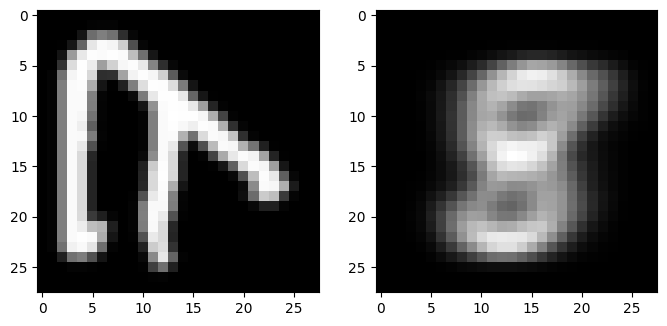

In [143]:
model.eval()

with torch.no_grad():
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    data = emnist_x[4009]
    data = data.view((-1,1,28,28)).to(device)
    mu, x_recon, flabels= model.forward(data)
    print(flabels[0])
    print(flabels[0][0:10].max())
    ax[0].imshow(data.view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[1].imshow(x_recon.view(28, 28).cpu().detach().numpy(), cmap='gray')